# E-commerce : boosting online sales with NLP !

## Introduction :

- In this project, I work with a corpus of item descriptions from an outdoor apparel brand's product catalog.
The dataset is available on Kaggle : https://www.kaggle.com/cclark/product-item-data?select=sample-data.csv

- The main goal is to use some NLP techniques to analyze text description of the product catalog in order to identify similar product, build a recommender system and create new topics with more meaning.

### Table of Contents

* [Part 1 : Preprocessing](#chapter1)
    * [Part 1.1 : Libraries & data loading](#section_1_1)
    * [Part 1.2 : Text preprocessings](#section_1_2)
    

* [Part 2 : Clustering model --> Identify similar products](#chapter2)

* [Part 3 : Recommender system](#chapter3)

* [Part 4 : LSA model --> topics extraction](#chapter4)


Pre-requisite : if necessary, install the required libraries for NLP (spacy, wordclouds) and download the english language model. Then, import all the libraries.

## Part 1 : Preprocessing <a class="anchor" id="chapter1"></a>

### Part 1.1 : Libraries & data loading <a class="anchor" id="section_1_1"></a>

Install libraries & load data

In [1]:
# Install spacy quietly
!pip install spacy -q

In [2]:
# Download english language model
!python -m spacy download en -q

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
# Install wordcloud
!pip install wordcloud

  Using cached wordcloud-1.8.1-cp38-cp38-manylinux1_x86_64.whl (371 kB)


1. Import pandas, numpy, spacy, sklearn (tfidf vectorizer, DBSCAN and TruncatedSVD), matplotlib and wordcloud

In [4]:
import pandas as pd
import numpy as np

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
import wordcloud

2. Reading the corpus and put it in a DataFrame named `corpus`. I print the full description in the first line

In [5]:
corpus = pd.read_csv('sample-data.csv')

In [6]:
print(corpus.shape)
corpus.head()

(500, 2)


,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


In [7]:
print('Description of the first product : ',corpus.loc[0,'description'])

Description of the first product :  Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program<br><br>

`Description is dirty due to HTML elements, punctuation and the not standardization of the words.`

### Part 1.2 : Text preprocessings <a class="anchor" id="section_1_2"></a>

3. Using `str` methods to clean the texts. I save the clean texts into a column named `clean_description`

In [8]:
# Remove HTML elements
corpus['clean_description'] = corpus['description'].str.replace(r"<[a-z/]+>", " ") 
# Remove special characters and numbers
corpus['clean_description'] = corpus['clean_description'].str.replace(r"[^A-Za-z]+", " ") 
print('Description cleaned of the first product : ',corpus.loc[0,'clean_description'])

Description cleaned of the first product :  Active classic boxers There s a reason why our boxers are a cult favorite they keep their cool especially in sticky situations The quick drying lightweight underwear takes up minimal space in a travel pack An exposed brushed waistband offers next to skin softness five panel construction with a traditional boxer back for a classic fit and a functional fly Made of oz recycled polyester with moisture wicking performance Inseam size M is Recyclable through the Common Threads Recycling Program Details Silky Capilene fabric is ultralight breathable and quick to dry Exposed brushed elastic waistband for comfort panel construction with traditional boxer back Inseam size M is Fabric oz all recycled polyester with Gladiodor natural odor control for the garment Recyclable through the Common Threads Recycling Program Weight g oz Made in Mexico 


4. Tranforming every character into lowercase.

In [9]:
# Lowercase
corpus['clean_description'] = corpus['clean_description'].str.lower()
print('Description in lower case of the first product : ',corpus.loc[0,'clean_description'])

Description in lower case of the first product :  active classic boxers there s a reason why our boxers are a cult favorite they keep their cool especially in sticky situations the quick drying lightweight underwear takes up minimal space in a travel pack an exposed brushed waistband offers next to skin softness five panel construction with a traditional boxer back for a classic fit and a functional fly made of oz recycled polyester with moisture wicking performance inseam size m is recyclable through the common threads recycling program details silky capilene fabric is ultralight breathable and quick to dry exposed brushed elastic waistband for comfort panel construction with traditional boxer back inseam size m is fabric oz all recycled polyester with gladiodor natural odor control for the garment recyclable through the common threads recycling program weight g oz made in mexico 


5. Using spacy to tokenize the documents and put the result in a new column named `clean_tokens`.

`Tokenization is a way of separating a piece of text into smaller units called tokens. Tokens can be either words, characters, or subwords.`

In [10]:
## Tokenize the cleaned description
corpus['clean_tokens'] = corpus['clean_description'].apply(lambda x: nlp(x))
corpus.head()

,id,description,clean_description,clean_tokens
0,1,Active classic boxers - There's a reason why o...,active classic boxers there s a reason why our...,"(active, classic, boxers, there, s, a, reason,..."
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning up glory re...,"(active, sport, boxer, briefs, skinning, up, g..."
2,3,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable no f...,"(active, sport, briefs, these, superbreathable..."
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...,"(alpine, guide, pants, skin, in, climb, ice, s..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...,"(alpine, wind, jkt, on, high, ridges, steep, i..."


6. Removing the stop words and lemmatize `clean_tokens`

- `Stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc.`
- `Lemmatization is a linguistic term that means grouping together words with the same root or lemma.`

In [11]:
# Remove stop words
from spacy.lang.en.stop_words import STOP_WORDS

corpus['clean_tokens'] = corpus['clean_tokens'].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
corpus.head()

,id,description,clean_description,clean_tokens
0,1,Active classic boxers - There's a reason why o...,active classic boxers there s a reason why our...,"[active, classic, boxer, s, reason, boxer, cul..."
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning up glory re...,"[active, sport, boxer, brief, skin, glory, req..."
2,3,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable no f...,"[active, sport, brief, superbreathable, fly, b..."
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...,"[alpine, guide, pant, skin, climb, ice, switch..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...,"[alpine, wind, jkt, high, ridge, steep, ice, a..."


7. Writing all the cleaned tokens into one single string and put it in a new column named `clean_document`.

In [12]:
# Put back tokens into one single string
corpus["clean_document"] = [" ".join(x) for x in corpus['clean_tokens']]
corpus.head()

,id,description,clean_description,clean_tokens,clean_document
0,1,Active classic boxers - There's a reason why o...,active classic boxers there s a reason why our...,"[active, classic, boxer, s, reason, boxer, cul...",active classic boxer s reason boxer cult favor...
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning up glory re...,"[active, sport, boxer, brief, skin, glory, req...",active sport boxer brief skin glory require mo...
2,3,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable no f...,"[active, sport, brief, superbreathable, fly, b...",active sport brief superbreathable fly brief m...
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...,"[alpine, guide, pant, skin, climb, ice, switch...",alpine guide pant skin climb ice switch rock t...
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...,"[alpine, wind, jkt, high, ridge, steep, ice, a...",alpine wind jkt high ridge steep ice alpine ja...


### Part 1 conclusion :
Now we have the `clean_document` feature which is cleaned. We can train some NLP model on it.

## Part 2 - Clustering model --> Identify similar products <a class="anchor" id="chapter2"></a>

1. TF-IDF transformation from the column `clean_document`

`TF-IDF (term frequency-inverse document frequency)` is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.

This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

In [19]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus["clean_document"])

# X is a generator. We can transform that as an array
X = X.toarray()
print(X.shape)

(500, 3529)


In [24]:
# Print the 50 first words into our vocabulary
print(sorted(vectorizer.vocabulary_.items())[:50])

[('abandon', 0), ('ability', 1), ('able', 2), ('abrasion', 3), ('abrasive', 4), ('abroad', 5), ('absolute', 6), ('absorb', 7), ('absorption', 8), ('abstract', 9), ('abuse', 10), ('abusive', 11), ('accentuate', 12), ('access', 13), ('accessibility', 14), ('accessory', 15), ('accommodate', 16), ('accomplish', 17), ('accord', 18), ('ace', 19), ('achieve', 20), ('achille', 21), ('act', 22), ('action', 23), ('active', 24), ('activity', 25), ('acutely', 26), ('adapt', 27), ('adaptability', 28), ('adaptable', 29), ('add', 30), ('addition', 31), ('additional', 32), ('adhere', 33), ('adjust', 34), ('adjustability', 35), ('adjustable', 36), ('adjustment', 37), ('adorn', 38), ('adour', 39), ('advance', 40), ('advanced', 41), ('advantage', 42), ('advantageous', 43), ('adventure', 44), ('aerial', 45), ('aesthetic', 46), ('affectionately', 47), ('afford', 48), ('aficionado', 49)]


2. Create a DataFrame containing the result from TF-IDF

In [25]:
# Create a dataframe with tf-idf
X_df = pd.DataFrame(X, 
             columns=vectorizer.get_feature_names(), 
             index=["item_{}".format(x) for x in range(corpus.shape[0])] )

X_df.head()

,abandon,ability,able,abrasion,abrasive,abroad,absolute,absorb,absorption,abstract,...,yvon,zinger,zip,zipped,zipper,zippered,zippers,zipping,zips,zone
item_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
item_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
item_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
item_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.197890,0.128476,0.0,0.0,0.0,0.0
item_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.108044,0.046764,0.0,0.0,0.0,0.0


- Each line of X correspond to a product description.
- Each column of X correspond to a word into the vocabulary.
- So each cell of X correspond to the score TF-IDF for a word into a product description.

3. Using DBSCAN to make some clustering on the TF-IDF matrix. 

- When dealing with texts, the distance metric to be used is `cosine` instead of "euclidean". 
- eps = 0.7 and min samples = 3 enable to have almost 15 clusters without too much outliers

In [40]:
# Clustering on documents with DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=3, metric="cosine", algorithm="brute")

# Fit on data 
#No need to normalize data, it already is due to TF-IDF
clustering.fit(X)

# Write cluster ids into corpus and X_df
corpus['cluster_id'] = clustering.labels_
display(corpus.head())
X_df['cluster_id'] = clustering.labels_
display(X_df.head())

,id,description,clean_description,clean_tokens,clean_document,cluster_id
0,1,Active classic boxers - There's a reason why o...,active classic boxers there s a reason why our...,"[active, classic, boxer, s, reason, boxer, cul...",active classic boxer s reason boxer cult favor...,0
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning up glory re...,"[active, sport, boxer, brief, skin, glory, req...",active sport boxer brief skin glory require mo...,0
2,3,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable no f...,"[active, sport, brief, superbreathable, fly, b...",active sport brief superbreathable fly brief m...,0
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...,"[alpine, guide, pant, skin, climb, ice, switch...",alpine guide pant skin climb ice switch rock t...,1
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...,"[alpine, wind, jkt, high, ridge, steep, ice, a...",alpine wind jkt high ridge steep ice alpine ja...,1


,abandon,ability,able,abrasion,abrasive,abroad,absolute,absorb,absorption,abstract,...,zinger,zip,zipped,zipper,zippered,zippers,zipping,zips,zone,cluster_id
item_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
item_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
item_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
item_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.197890,0.128476,0.0,0.0,0.0,0.0,1
item_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.108044,0.046764,0.0,0.0,0.0,0.0,1


4. Display number of documents in each cluster

In [41]:
# Number of documents in each cluster
corpus['cluster_id'].value_counts()

 1     222
 0      68
 4      57
-1      31
 2      30
 9      24
 15     13
 3       9
 6       8
 8       8
 12      7
 11      5
 10      4
 7       4
 14      4
 5       3
 13      3
Name: cluster_id, dtype: int64

5. Print a sample of 3 documents that belong to 5 clusters

In [50]:
# Print sample of 3 documents for the 5 first cluster
for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c , ' :')
    print('----')
    for d in corpus.loc[corpus['cluster_id']==c,:].sample(3)['clean_description']:
        print(d)
        print()
    print('-----------')

CLUSTER  1  :
----
rain shadow pants light enough to be an afterthought until the downpour our rain shadow pants provide fully seam sealed waterproof breathable protection they re made from packable lightweight and tear resistant layer nylon with a waterproof breathable h no barrier and a deluge dwr durable water repellent finish on the inside a raised pattern diffuses and channels moisture away from the skin aids in hassle free layering and enhances long term durability features include a buttoned zip fly separating waistband with partial elastic a cleaner more comfortable finish anatomically contoured knees and new fully separating side zips with snap closures at the ankle and waist gripper elastic cuffs details layer tear resistant fabric with a waterproof breathable h no barrier and deluge dwr durable water repellent finish highly engineered interior surface texture channels moisture away from skin protects the waterproof barrier from abrasion and slides easily over layers updated 

6. Print the 5 most frequent words in the 5 first clusters

In [54]:
# 5 Most frequent words in each cluster
cols = [c for c in X_df.columns if c!='cluster_id']

for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c)
    print(X_df.loc[X_df['cluster_id']==c,cols].mean(axis=0).sort_values(ascending=False)[0:5])
    print('-----------')

CLUSTER  1
pocket     0.090312
recycle    0.064573
organic    0.058539
cotton     0.057154
oz         0.057065
dtype: float64
-----------
CLUSTER  0
sun          0.111609
recycle      0.098168
polyester    0.094980
upf          0.086771
control      0.084073
dtype: float64
-----------
CLUSTER  4
shirt        0.174756
ringspun     0.166898
print        0.163308
phthalate    0.161449
pvc          0.159772
dtype: float64
-----------
CLUSTER  -1
cotton     0.088111
organic    0.088111
oz         0.055654
spandex    0.055065
pocket     0.050137
dtype: float64
-----------
CLUSTER  2
pocket          0.135494
strap           0.117966
mesh            0.114475
polyurethane    0.097491
compartment     0.090680
dtype: float64
-----------


7. Wordcloud for the 5 first clusters

CLUSTER  1


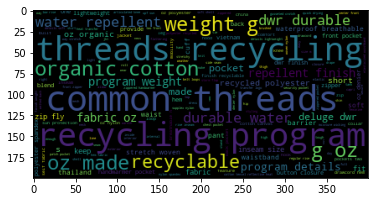

-----------
CLUSTER  0


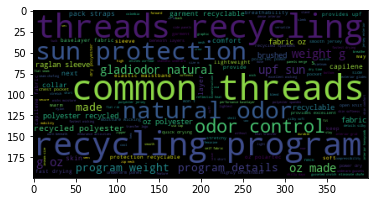

-----------
CLUSTER  4


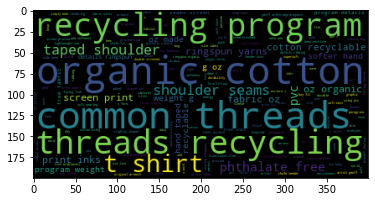

-----------
CLUSTER  -1


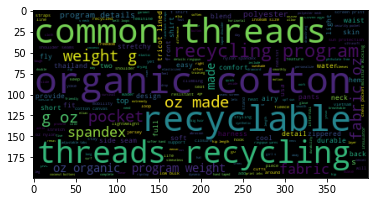

-----------
CLUSTER  2


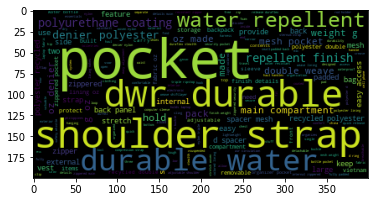

-----------


In [55]:
# Word cloud for the 5 first clusters
wd = wordcloud.WordCloud()
for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c)
    texts = " ".join(corpus.loc[corpus['cluster_id']==c,'clean_description'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    print('-----------')

## Part 3 - Recommender system <a class="anchor" id="chapter3"></a>

Now, we use the clusters created from part 1 to build a recommender system. 
The aim is to be able to suggest to a user some products that are similar to the ones he is interested in. To do this, we consider that products belonging to the same cluster are similar.

In [22]:
corpus.head()

,id,description,clean_description,clean_tokens,clean_document,cluster_id
0,1,Active classic boxers - There's a reason why o...,active classic boxers there s a reason why our...,"[active, classic, boxer, s, reason, boxer, cul...",active classic boxer s reason boxer cult favor...,0
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning up glory re...,"[active, sport, boxer, brief, skin, glory, req...",active sport boxer brief skin glory require mo...,0
2,3,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable no f...,"[active, sport, brief, superbreathable, fly, b...",active sport brief superbreathable fly brief m...,0
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...,"[alpine, guide, pant, skin, climb, ice, switch...",alpine guide pant skin climb ice switch rock t...,1
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...,"[alpine, wind, jkt, high, ridge, steep, ice, a...",alpine wind jkt high ridge steep ice alpine ja...,1


1. We Create a function named `find_similar_items` that return the 5 items ids belonging to the same cluster as the product `item_id` which is passed in arguments

In [70]:
def find_similar_items(item_id):
    """
    Return 5 product ids belonging to the same cluster as item_id
    """
    cluster_id = corpus.loc[corpus['id']==item_id, 'cluster_id'].values[0]
    similar_items = corpus.loc[corpus['cluster_id']==cluster_id,:].sample(5)
    similar_item_ids = similar_items['id'].unique()
    return similar_item_ids

2. Using python's `input()` function to allow the user to choose a product and submit some suggestions of similar items

In [91]:
# For printing in colors
class bcolors:
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'

In [92]:
product_id = int(input("What product would you like to buy ? "))
print()
try:
    item_desc = corpus.loc[corpus['id']==product_id, 'clean_description'].values[0]
except:
    print('Product not found in database. Please enter a valid product id.')
else:
    print(f"{bcolors.OKBLUE}Product found in database, description below :")
    print(item_desc)
    print()
    
    print("Based on the analysis of the products' descriptions, you might also be interested by the following products : ")
    print()

    for i in find_similar_items(product_id):
        print(f"{bcolors.OKGREEN}Item #", i)
        print(corpus.loc[corpus['id']==i, 'clean_description'].values[0])
        print('--------------------')

What product would you like to buy ?  6



Product found in database, description below :
ascensionist jkt our most technical soft shell for full on mountain pursuits strikes the alpinist s balance between protection and minimalism the dense way stretch polyester double weave with stitchless seams has exceptional water and wind resistance a rapid dry time and superb breathability pared down detailing provides everything you need and nothing more a way adjustable helmet compatible hood a reverse coil center front zipper with a dwr durable water repellent finish large external handwarmer pockets with zipper garages that are placed above the harness line an internal security pocket articulated arms self fabic cuff tabs a drawcord hem recyclable through the common threads recycling program details dense stretchy polyester double weave fabric is exceptionally water and wind resistant and is spandex free for fast dry times stitch free lap glued seams speed dry time improve water resistance and decrease bulk helmet compatible way adj

## Part 4 - LSA for topic extraction <a class="anchor" id="chapter4"></a>

- Latent Semantic Analysis, or LSA, is one of the foundational techniques in topic modeling. The core idea is to take a matrix of what we have — documents and terms — and decompose it into a separate document-topic matrix and a topic-term matrix.

- The main goal of this part is to find relevant topics for each documents. Contrary to clustering, a unique documents can have multiple topics. For example Sport and Politics.

1. Using TruncatedSVD to make some topic extraction from the TF-IDF matrix.

In [94]:
# Train SVD model
svd_model = TruncatedSVD(n_components=12) # We test on 12 topics
lsa = svd_model.fit_transform(X)
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_" + str(i) for i in range(lsa.shape[1])])
topic_encoded_df["documents"] = corpus['clean_description']
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents
0,0.277859,-0.042782,0.186374,0.102656,-0.114495,0.014305,-0.081318,-0.002719,-0.136056,-0.056938,-0.040323,0.006423,active classic boxers there s a reason why our...
1,0.301520,-0.051624,0.102655,0.108851,-0.022233,0.144951,-0.007481,-0.009309,-0.082392,-0.106934,-0.060735,0.040553,active sport boxer briefs skinning up glory re...
2,0.290454,-0.074980,0.108657,0.029574,-0.024166,0.117563,0.089906,0.065186,-0.056456,-0.036748,-0.036026,0.097527,active sport briefs these superbreathable no f...
3,0.414399,-0.260906,-0.114428,-0.149972,0.037065,-0.006103,-0.052230,-0.120594,-0.006875,-0.142804,-0.045661,-0.110944,alpine guide pants skin in climb ice switch to...
4,0.402028,-0.273101,-0.019426,-0.250356,-0.039114,-0.062670,0.023926,0.000605,0.104562,-0.156286,-0.018029,-0.217857,alpine wind jkt on high ridges steep ice and a...


Contrary to clustering, LSA allows to map each document to a mixing of several topics. For this reason, it's a bit more difficult to interpret the topics as categories : one document can actually be related to several topics at a time. To make things easier, we can extract the main topic of each document.

2. Creation of a new column named `main_topic` in `topic_encoded_df` where we store the main topics related to each document

In [99]:
def extract_main_topics(x):
    """
    Return the main topic for each document. The main topic is that have the maximum value for each line
    """
    topics = np.abs(x)
    main_topic = topics.sort_values(ascending=False).index[0]
    return main_topic

# Initialize column main_topics with 0
topic_encoded_df.loc[:, 'main_topic'] = 0

for i, row in topic_encoded_df.iloc[:,:-2].iterrows():
    topic_encoded_df.loc[i, 'main_topic'] = extract_main_topics(row)

topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.277859,-0.042782,0.186374,0.102656,-0.114495,0.014305,-0.081318,-0.002719,-0.136056,-0.056938,-0.040323,0.006423,active classic boxers there s a reason why our...,topic_0
1,0.301520,-0.051624,0.102655,0.108851,-0.022233,0.144951,-0.007481,-0.009309,-0.082392,-0.106934,-0.060735,0.040553,active sport boxer briefs skinning up glory re...,topic_0
2,0.290454,-0.074980,0.108657,0.029574,-0.024166,0.117563,0.089906,0.065186,-0.056456,-0.036748,-0.036026,0.097527,active sport briefs these superbreathable no f...,topic_0
3,0.414399,-0.260906,-0.114428,-0.149972,0.037065,-0.006103,-0.052230,-0.120594,-0.006875,-0.142804,-0.045661,-0.110944,alpine guide pants skin in climb ice switch to...,topic_0
4,0.402028,-0.273101,-0.019426,-0.250356,-0.039114,-0.062670,0.023926,0.000605,0.104562,-0.156286,-0.018029,-0.217857,alpine wind jkt on high ridges steep ice and a...,topic_0


3. Couting each main topic in the corpus 

In [100]:
topic_encoded_df['main_topic'].value_counts()

topic_0     268
topic_1      61
topic_6      38
topic_2      35
topic_7      29
topic_3      17
topic_4      13
topic_11     11
topic_8       8
topic_10      8
topic_5       7
topic_9       5
Name: main_topic, dtype: int64

- topic_0 is the most represented topic, as it's the main topic for more than `50%` of the documents of the corpus.

4. Using the attribute `components_` of the SVD model to print the 5 most important words in each topic

In [29]:
# Create DataFrame containing the description of each topic in terms of the words in the vocabulary
topics_description = pd.DataFrame(svd_model.components_, columns = vectorizer.get_feature_names(), 
                                  index = ['topic_' + str(i) for i in range(svd_model.components_.shape[0])])

# Compute absolute values of coefficients
topics_description = topics_description.apply(np.abs, axis = 1)

# Each word is map with a score of relevance for each topic
topics_description.head()

,abandon,ability,able,abrasion,abrasive,abroad,absolute,absorb,absorption,abstract,...,young,yvon,zest,zinger,zip,zipper,zippered,zippers,zone,zones
topic_0,0.001093,0.002232,0.000390,0.019024,0.000787,0.000893,0.000893,0.001192,0.001319,0.001334,...,0.000674,0.001546,0.001126,0.000614,0.089621,0.102481,0.049830,0.006719,0.005494,0.001884
topic_1,0.000468,0.000817,0.000408,0.023102,0.000691,0.000877,0.000621,0.001734,0.001440,0.003814,...,0.000483,0.004725,0.001480,0.000847,0.059682,0.121308,0.055642,0.009663,0.007628,0.003234
topic_2,0.003379,0.005973,0.000065,0.018337,0.000097,0.000089,0.002130,0.001078,0.000532,0.000546,...,0.000315,0.000690,0.000328,0.000778,0.070365,0.060387,0.041074,0.005974,0.002067,0.002436
topic_3,0.000621,0.000276,0.000074,0.012859,0.000811,0.002039,0.000233,0.003253,0.000150,0.002143,...,0.001131,0.003276,0.002808,0.000833,0.076245,0.132625,0.043192,0.015554,0.011318,0.006168
topic_4,0.004126,0.009284,0.000691,0.017551,0.000854,0.000304,0.001708,0.000741,0.000376,0.000067,...,0.000108,0.000540,0.000549,0.000409,0.012219,0.005006,0.009681,0.004994,0.016531,0.003395


In [30]:
# Loop over each topic and print the 5 most important words
for i,row in topics_description.iterrows():
    print('TOPIC :', i)
    print(row.sort_values(ascending=False)[0:5].index.tolist())
    print()
    print('-------------------------')
    print()

TOPIC  topic_0
['recycle', 'pocket', 'oz', 'organic', 'cotton']

-------------------------

TOPIC  topic_1
['organic', 'cotton', 'shirt', 'print', 'ringspun']

-------------------------

TOPIC  topic_2
['merino', 'odor', 'pocket', 'wool', 'control']

-------------------------

TOPIC  topic_3
['inseam', 'organic', 'cotton', 'button', 'short']

-------------------------

TOPIC  topic_4
['merino', 'wool', 'wash', 'sun', 'capilene']

-------------------------

TOPIC  topic_5
['nylon', 'sun', 'organic', 'cotton', 'fleece']

-------------------------

TOPIC  topic_6
['spandex', 'coverage', 'tencel', 'inseam', 'pocket']

-------------------------

TOPIC  topic_7
['strap', 'mesh', 'waterproof', 'polyurethane', 'barrier']

-------------------------

TOPIC  topic_8
['sun', 'upf', 'protection', 'collar', 'recycled']

-------------------------

TOPIC  topic_9
['fleece', 'waterproof', 'barrier', 'sun', 'organic']

-------------------------

TOPIC  topic_10
['photo', 'poster', 'outside', 'passion', 

5. Make a wordcloud describing each topic and compare to the ones we obtain with clustering

In [31]:
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.258892,-0.042789,0.170607,0.097877,-0.108126,0.021663,-0.077952,0.002239,-0.107902,-0.022689,0.013688,0.020526,active classic boxers there s a reason why our...,topic_0
1,0.298290,-0.052721,0.099568,0.108462,-0.023279,0.144617,-0.018348,-0.012981,-0.110490,-0.101396,-0.016632,-0.040665,active sport boxer briefs skinning up glory re...,topic_0
2,0.287659,-0.079383,0.103528,0.029478,-0.031287,0.129417,0.093217,0.062452,-0.065186,-0.032789,-0.011549,-0.112170,active sport briefs these superbreathable no f...,topic_0
3,0.414784,-0.268201,-0.115953,-0.156317,0.040242,-0.024274,-0.059828,-0.123108,-0.041636,-0.135200,0.009130,0.086610,alpine guide pants skin in climb ice switch to...,topic_0
4,0.389376,-0.266605,-0.015727,-0.245582,-0.036587,-0.059890,0.038446,-0.010270,0.065317,-0.166139,0.019618,0.231450,alpine wind jkt on high ridges steep ice and a...,topic_0


-------------------------

TOPIC  topic_0


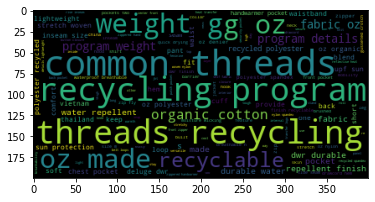


-------------------------

TOPIC  topic_1


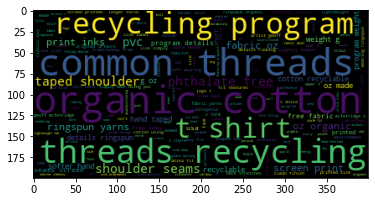


-------------------------

TOPIC  topic_2


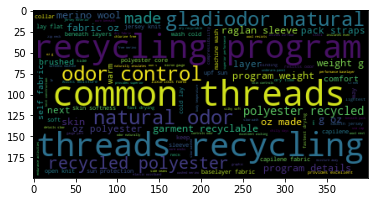


-------------------------

TOPIC  topic_3


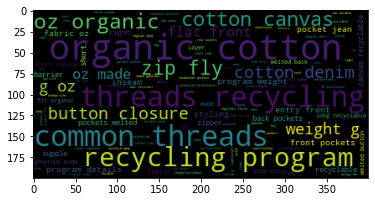


-------------------------

TOPIC  topic_4


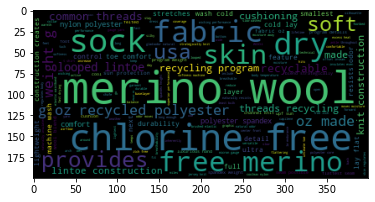


-------------------------

TOPIC  topic_5


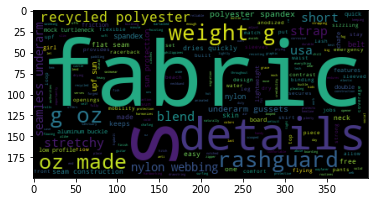


-------------------------

TOPIC  topic_6


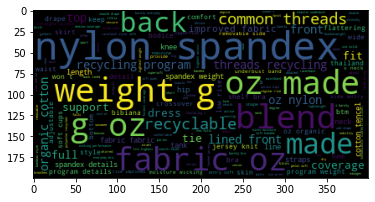


-------------------------

TOPIC  topic_7


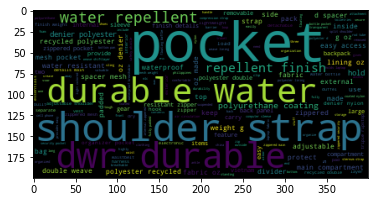


-------------------------

TOPIC  topic_8


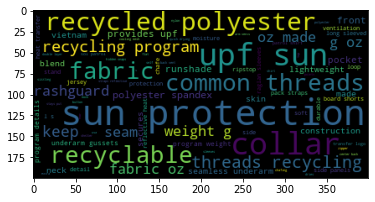


-------------------------

TOPIC  topic_9


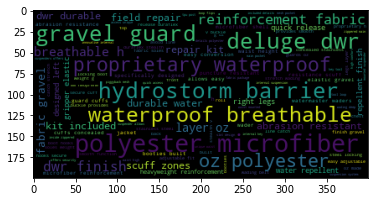


-------------------------

TOPIC  topic_10


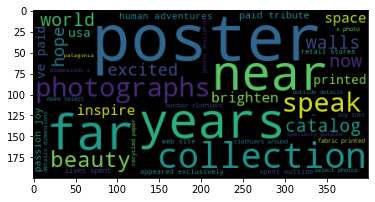


-------------------------

TOPIC  topic_11


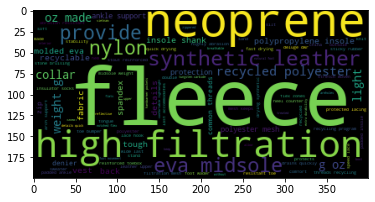

In [32]:
# Loop over each topic and create wordcloud from documents that are related to this main topic
wd = wordcloud.WordCloud()

cols = [c for c in topic_encoded_df.columns if 'topic_' in c]

for t in cols:
    print('-------------------------')
    print()
    print('TOPIC ', t)
    
    # Handle topics that are not main topics for any document in the corpus
    if (topic_encoded_df['main_topic']==t).any() == False :
        print('cannot create wordcloud for this topic')
        continue
    
    texts = " ".join(topic_encoded_df.loc[topic_encoded_df['main_topic']==t,'documents'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    
    print()

## Conclusion

- It's difficult to compare the results from the clustering and LSA, in particular because we didn't get exactly the same number of "topics" for both algorithms. However, the wordclouds are not fundamentally different (for example, both algorithms identify a group of documents or topic related to sun protection, organic cotton or merino wood).

- The major difference between these two approaches is that clustering maps a given document to a single group, whereas LSA links a document to several topics. For this reason, text clustering is usually more suitable for applications related to similarity measurements (for example, building a recommender system),  whereas LSA is widely used for topic modelling.